In [1]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from keras.callbacks import ProgbarLogger
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ProgbarLogger
import tensorflow_hub as hub

[data](https://www.kaggle.com/datasets/team-ai/spam-text-message-classification)

In [99]:
# Read the data from the CSV file
df = pd.read_csv('SPAM.csv')

# Perform oversampling to balance the classes
X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values
over = RandomOverSampler()
X, y = over.fit_resample(X, y)

In [100]:
from sklearn.preprocessing import LabelEncoder

# Perform label encoding on y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Concatenate features and labels
y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=2)
data = np.concatenate((X, y_one_hot), axis=1)


In [101]:
# Assuming you want to remove column at index 2
column_to_remove = 2
data = np.delete(data, column_to_remove, axis=1)


In [102]:
# Create a new DataFrame with the updated data
df = pd.DataFrame(data, columns=df.columns[::-1])

In [103]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [105]:
# Function to convert DataFrame to TensorFlow Dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('Category')
    df = df["Message"]
    labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=2)
    ds = tf.data.Dataset.from_tensor_slices((df, labels_one_hot))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [107]:
# Convert the data splits to TensorFlow Datasets
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

#Embedding + Model

In [108]:
# Define the embedding layer
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [111]:
# Create the model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(2, activation="sigmoid"))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy']
)

# Evaluate the model on the train_data
model.evaluate(train_data)


8/8 [==============================] - 0s 8ms/step - loss: 0.1748 - accuracy: 0.5047


[0.1748175472021103, 0.5046632289886475]

In [112]:
history =model.fit(train_data,batch_size=64, epochs=20, validation_data=val_data, verbose=0, callbacks=[ProgbarLogger(count_mode='steps')])

In [114]:
accuracy = model.evaluate(test_data, verbose=0)[1]
print(f"accuracy = {accuracy}")


accuracy = 0.99689120054245


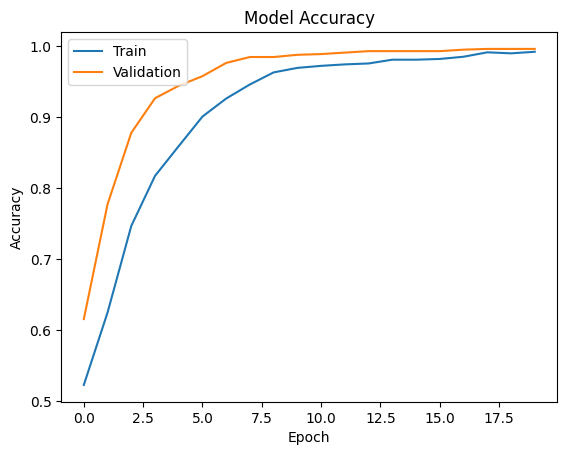

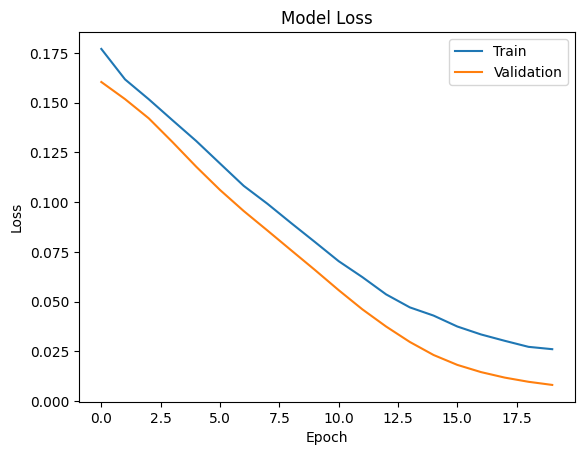

In [115]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()